In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

2023-05-05 14:06:56.073779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FOOD_PATH = "food/"
FOOD_DIR = glob.glob("food/*")
CATEGORIES_PATH = "categories.csv"

MODELS = ["sg-food-233-densenet121", "sg-food-233-densenet201", "sg-food-233-xception"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

TOP_N = 5

In [3]:
categories = list(pd.read_csv(CATEGORIES_PATH, header=None)[0])

In [4]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [5]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [6]:
models = load_models()

2023-05-05 14:07:02.211869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Models Loaded


In [7]:
def predict(model, filepath, top_n=1):
    test_image = load_img(filepath, target_size=(512, 512))
    test_image_array = img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)
    test_image_array = test_image_array / 255.
    prediction = model.predict(test_image_array, verbose=0)
    predicted_label = np.argsort(prediction[0])[::-1][:top_n]
    predicted_score = prediction[0][predicted_label]
    return predicted_label, predicted_score

In [8]:
def ensemble_predict(filepath, top_n=1):
    predicted_labels = []
    predicted_scores = []
    prediction = {}
    for model in models:
        predicted_label, predicted_score = predict(model, filepath, top_n)
        predicted_labels = predicted_labels + list(predicted_label)
        predicted_scores = predicted_scores + list(predicted_score)
        for i, label in enumerate(predicted_labels):
            if predicted_labels[i] in prediction:
                if prediction[categories[predicted_labels[i]]] < predicted_scores[i]:
                    prediction[categories[predicted_labels[i]]] = predicted_scores[i]
            else:
                prediction[categories[predicted_labels[i]]] = predicted_scores[i]
    prediction = dict(sorted(prediction.items(), key=lambda item : item[1], reverse=True)[:top_n])
    return prediction

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

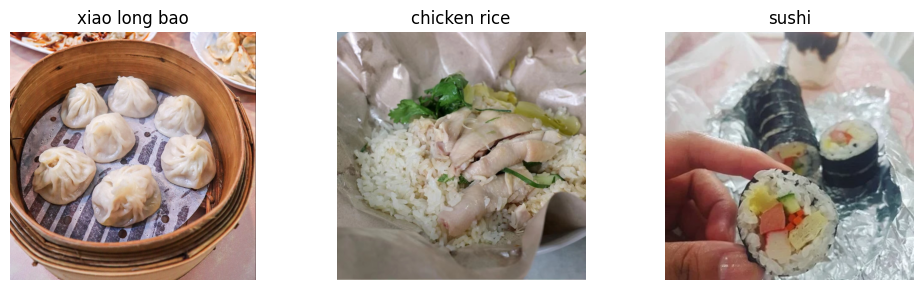

In [9]:
plt.figure(figsize=(10, 3))

for idx, food in enumerate(FOOD_DIR):
    pred = ensemble_predict(food, TOP_N)
    plt.subplot(1, len(FOOD_DIR), idx + 1)
    img = plt.imread(food)
    plt.title(list(pred.keys())[0])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    print("=" * 50)
    print(list(pred.keys())[0])
    print(pred)
    print("=" * 50)
plt.tight_layout()